In [1]:
import json
import seaborn 
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVR
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder,KBinsDiscretizer
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score,KFold,cross_val_predict
from sklearn.metrics import r2_score,mean_squared_error,roc_curve,confusion_matrix,accuracy_score

In [177]:
df = pd.read_json(path_or_buf = 'predictionQuery_Train2.json', orient='records')
df
#df = pd.read_csv('predictionQuery_Train.csv')
#df.head(50)

,lon,lat,ROUTE_NUMBER,DELAY,Current_Stop,From,Destination,Direction,Current_Time,Current_Day,Current_Hour,Current_Minutes,Current_Seconds
0,21.94706,48.96574,Os 8912,0,Udavské,Medzilaborce mesto,Humenné,1,2021-03-09 10:18:54.687,9,11,18,54
1,20.81501,48.81167,Os 7415,0,Mníšek nad Hnilcom,Nálepkovo,Margecany,7,2021-03-09 10:19:54.642,9,11,19,54
2,20.56151,48.95041,R 601 TATRAN,300,Spišská Nová Ves,Bratislava hlavná stanica,Košice,20,2021-03-09 10:13:54.529,9,11,13,54
3,21.24601,48.79580,Os 7814,0,Kostoľany nad Hornádom,Košice,Poprad-Tatry,9,2021-03-09 10:29:24.696,9,11,29,24
4,20.63426,48.91024,Os 7817,0,Markušovce,Poprad-Tatry,Košice,17,2021-03-09 10:37:54.796,9,11,37,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,20.94725,48.85834,Os 7431,0,Gelnica,Nálepkovo,Margecany,7,2021-03-10 18:38:00.797,10,19,38,0
1750,20.94725,48.85834,Os 7431,0,Gelnica,Nálepkovo,Margecany,7,2021-03-10 18:38:30.847,10,19,38,30
1751,21.22393,48.85288,Os 7830,120,Kysak,Košice,Svit,51,2021-03-10 18:38:30.847,10,19,38,30
1752,20.94725,48.85834,Os 7431,0,Gelnica,Nálepkovo,Margecany,7,2021-03-10 18:38:45.786,10,19,38,45


In [178]:
df.describe()

,lon,lat,DELAY,Direction,Current_Day,Current_Hour,Current_Minutes,Current_Seconds
count,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000
mean,21.326653,48.884836,134.914481,18.898518,9.204105,12.858609,27.282782,37.132269
std,0.437262,0.174052,280.187613,14.645145,0.582562,5.027190,18.712429,16.124893
min,20.471821,48.390320,-240.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,21.013240,48.811670,0.000000,9.000000,9.000000,9.000000,11.000000,26.000000
50%,21.249126,48.873332,0.000000,17.000000,9.000000,14.000000,26.000000,40.000000
75%,21.751880,48.983379,240.000000,23.000000,10.000000,16.000000,43.000000,53.000000
max,22.172956,49.308340,4080.000000,72.000000,10.000000,23.000000,59.000000,59.000000


In [179]:
df.isnull().sum()

lon                0
lat                0
ROUTE_NUMBER       0
DELAY              0
Current_Stop       0
From               0
Destination        0
Direction          0
Current_Time       0
Current_Day        0
Current_Hour       0
Current_Minutes    0
Current_Seconds    0
dtype: int64

In [180]:
df.dtypes

lon                       float64
lat                       float64
ROUTE_NUMBER               object
DELAY                       int64
Current_Stop               object
From                       object
Destination                object
Direction                   int64
Current_Time       datetime64[ns]
Current_Day                 int64
Current_Hour                int64
Current_Minutes             int64
Current_Seconds             int64
dtype: object

In [181]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

<AxesSubplot:>

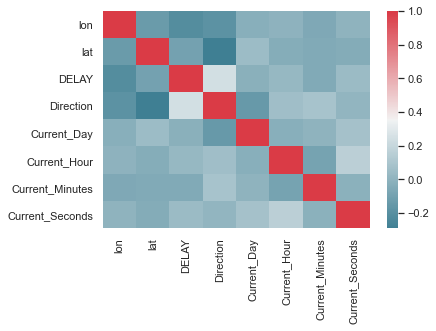

In [182]:
seaborn.set(style='white')
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
seaborn.heatmap(df.corr(),cmap=cmap)

In [183]:
df = df.drop("Current_Time",axis = 1)

In [184]:
def LabelEncoding(col):
    encoder = LabelEncoder()
    encoder.fit(df[col])
    list(encoder.classes_)
    return encoder.transform(df[col])

def KBinsDiscretizing(currCol):
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    discretizer.fit(df[currCol])
    return discretizer.transform(df[currCol])

df['Current_Stop_Encoded']=LabelEncoding('Current_Stop')
df['From_Encoded']=LabelEncoding('From')
df['Destination_Encoded']=LabelEncoding('Destination')
df['lon_Encoded']=LabelEncoding('lon')
df['lat_Encoded']=LabelEncoding('lat')
df['Current_Seconds_Encoded']=LabelEncoding('Current_Seconds')
df['Current_Minutes_Encoded']=LabelEncoding('Current_Minutes')
df['Current_Hour_Encoded']= LabelEncoding('Current_Hour')
df['Current_Day_Encoded']= LabelEncoding('Current_Day')
df['ROUTE_NUMBER_Encoded'] = LabelEncoding('ROUTE_NUMBER')

In [185]:
df.head()

,lon,lat,ROUTE_NUMBER,DELAY,Current_Stop,From,Destination,Direction,Current_Day,Current_Hour,...,Current_Stop_Encoded,From_Encoded,Destination_Encoded,lon_Encoded,lat_Encoded,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,ROUTE_NUMBER_Encoded
0,21.94706,48.96574,Os 8912,0,Udavské,Medzilaborce mesto,Humenné,1,9,11,...,53,13,5,57,47,53,18,9,1,148
1,20.81501,48.81167,Os 7415,0,Mníšek nad Hnilcom,Nálepkovo,Margecany,7,9,11,...,29,16,9,11,27,53,19,9,1,26
2,20.56151,48.95041,R 601 TATRAN,300,Spišská Nová Ves,Bratislava hlavná stanica,Košice,20,9,11,...,47,2,6,4,45,53,13,9,1,244
3,21.24601,48.79580,Os 7814,0,Kostoľany nad Hornádom,Košice,Poprad-Tatry,9,9,11,...,13,7,16,25,25,23,29,9,1,52
4,20.63426,48.91024,Os 7817,0,Markušovce,Poprad-Tatry,Košice,17,9,11,...,25,17,6,7,39,53,37,9,1,54


In [186]:
df = df.drop(['ROUTE_NUMBER','Current_Stop','Current_Hour','Current_Minutes',
              'Current_Seconds','lon','lat',"Destination","From",
              'Current_Day'],axis =1, errors='ignore')

,DELAY,Direction,Current_Stop_Encoded,From_Encoded,Destination_Encoded,lon_Encoded,lat_Encoded,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,ROUTE_NUMBER_Encoded
0,0,1,53,13,5,57,47,53,18,9,1,148
1,0,7,29,16,9,11,27,53,19,9,1,26
2,300,20,47,2,6,4,45,53,13,9,1,244
3,0,9,13,7,16,25,25,23,29,9,1,52
4,0,17,25,17,6,7,39,53,37,9,1,54
5,0,8,55,7,27,55,0,53,39,9,1,127
6,120,10,27,5,6,52,24,53,53,9,1,280
7,360,15,60,7,5,42,11,38,48,9,1,273
8,0,8,3,7,27,61,4,38,48,9,1,127
9,0,13,26,5,11,54,62,53,52,9,1,149


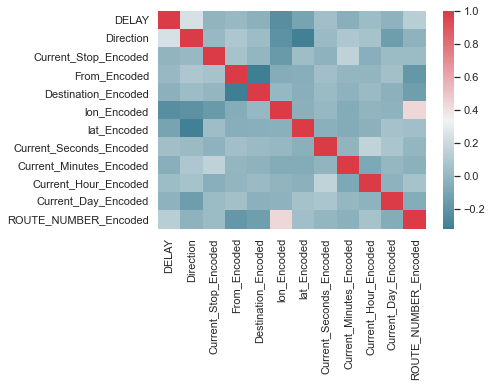

In [187]:
seaborn.heatmap(df.corr(),cmap=cmap)
df.head(10)

In [188]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('lon_Encoded', 'ROUTE_NUMBER_Encoded')]

In [189]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr < -0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('Direction', 'lat_Encoded'), ('From_Encoded', 'Destination_Encoded')]

In [190]:
df = df.drop(['lon_Encoded','lat_Encoded','From_Encoded'],axis =1, errors='ignore')

In [191]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

In [192]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr < -0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

<Figure size 6000x3000 with 0 Axes>

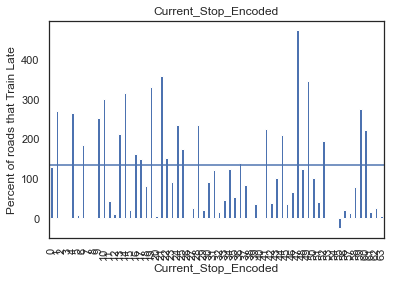

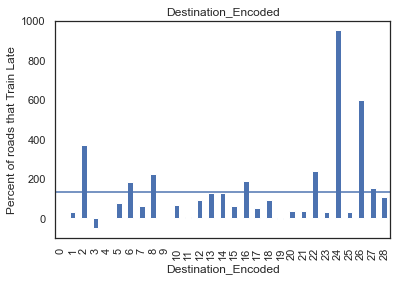

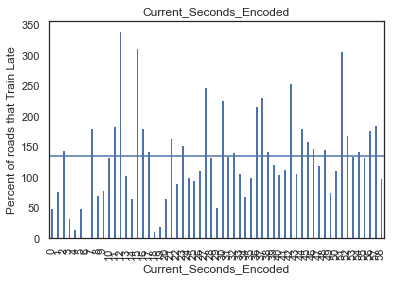

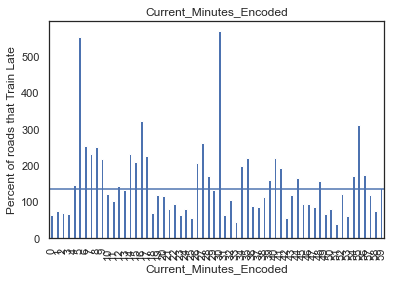

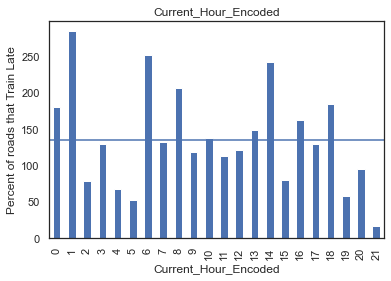

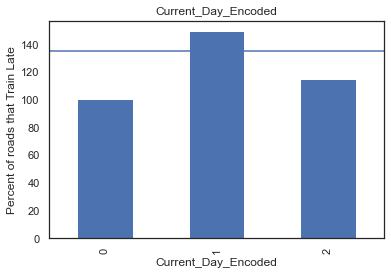

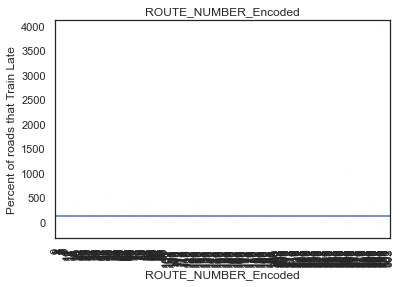

In [193]:
avgLate = np.sum(df['DELAY'])/len(df['DELAY'])
attributes = ['Current_Stop_Encoded','Destination_Encoded',
              'Current_Seconds_Encoded','Current_Minutes_Encoded','Current_Hour_Encoded',
              'Current_Day_Encoded','ROUTE_NUMBER_Encoded']
for i,pred in enumerate(attributes):
    plt.figure(i, figsize=(20, 10),dpi=300)
    group = df.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'DELAY']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='DELAY')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('Percent of roads that Train Late')
    plt.title(pred)
    plt.legend().remove()

In [194]:
train_x, test_x, train_y, test_y = train_test_split(df.drop('DELAY', axis=1), df['DELAY'], test_size=0.3, random_state=1234)

In [195]:
print(train_x.shape +  test_x.shape)

(1227, 8, 527, 8)


In [196]:
print(train_y.shape +  test_y.shape)

(1227, 527)


#### GridSearch for RandomForest

In [197]:
startTimeGS = datetime.now()
param_grid = {'n_estimators': [10,15,20,25,100,500,600,700,800,900,1000]}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('Random forest Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

Random forest Grid Search with non-redundant variables took [ 0:04:50.741450 ] seconds.


In [198]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestRegressor(n_estimators=500)
{'n_estimators': 500}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [10, 15, 20, 25, 100, 500, 600, 700,
                                          800, 900, 1000]})>

#### RandomForest

In [199]:
regr = RandomForestRegressor(n_estimators = bestParameters.get('n_estimators'),
                             random_state = 1234)
model = regr.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_Random_Forrest = regr.predict(test_x)
regr.score(test_x,test_y)

0.821287853174596
0.11585722833927785
[0.71087476 0.93323699 0.92728749 0.80134411 0.71874114 0.6001052
 0.9288221  0.95480221 0.75163001 0.88603452]


0.8860267460584821

In [200]:
y_pred= y_pred_Random_Forrest
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred_Random_Forrest))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred_Random_Forrest))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred_Random_Forrest, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred_Random_Forrest))
print('Max Error:', metrics.max_error(y_true, y_pred_Random_Forrest))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred_Random_Forrest))
print('R^2:', metrics.r2_score(y_true, y_pred_Random_Forrest))

Mean Absolute Error (MAE): 59.75111954459203
Mean Squared Error (MSE): 10918.080355218213
Root Mean Squared Error (RMSE): 104.48961840880754
Explained Variance Score: 0.886070577567893
Max Error: 717.36
Median Absolute Error: 27.840000000000003
R^2: 0.8860267460584821


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

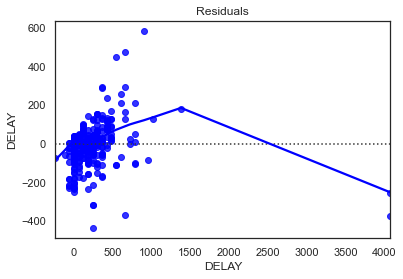

In [201]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

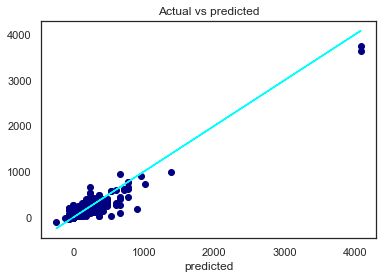

In [202]:
y_pred= regr.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.xlabel('Actual')
plt.xlabel('predicted')
plt.title('Actual vs predicted')

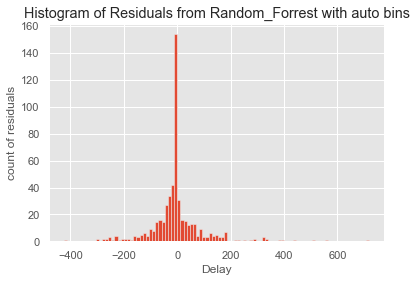

In [203]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram of Residuals from Random_Forrest with auto bins")
plt.show()

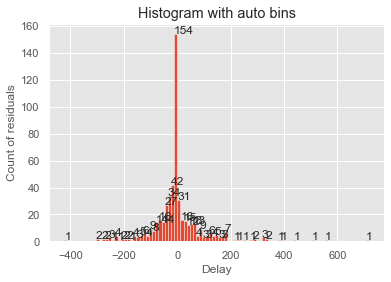

In [204]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridSearch for Linear Regression

In [205]:
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True,False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

LinearRegression(fit_intercept=False, normalize=True)
{'copy_X': True, 'fit_intercept': False, 'normalize': True}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]})>

#### LinearRegression

In [206]:
regressor = LinearRegression(fit_intercept=bestParameters.get('fit_intercept'),
                             normalize=bestParameters.get('normalize'), 
                             copy_X=bestParameters.get('copy_X'))  
regressor.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regressor, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(regressor, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_Linear_Regression = regressor.predict(test_x)
regressor.score(test_x,test_y)

0.0033944726961108508
0.14324773177426156
[-1.76153132e-01  9.75469870e-02  1.15656086e-01 -1.52608770e-04
 -3.33020797e-01  5.99355113e-02  1.13064064e-01  1.09339397e-01
 -5.03644762e-02  9.80936952e-02]


0.07448772541013093

In [207]:
y_pred= y_pred_Linear_Regression
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 156.6667034644996
Mean Squared Error (MSE): 88659.54980014844
Root Mean Squared Error (RMSE): 297.75753525334744
Explained Variance Score: 0.07486858550966025
Max Error: 3737.1211284866154
Median Absolute Error: 113.54153571733966
R^2: 0.07448772541013093


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

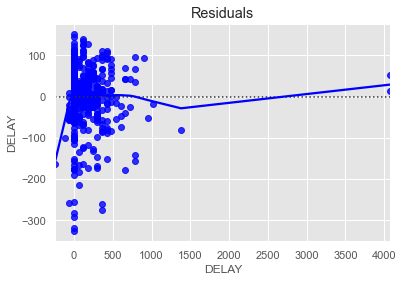

In [208]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

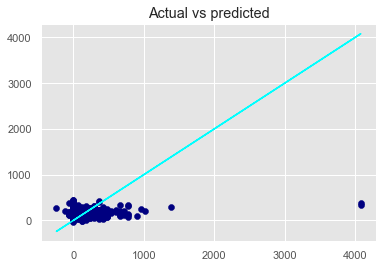

In [209]:
y_pred= regressor.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

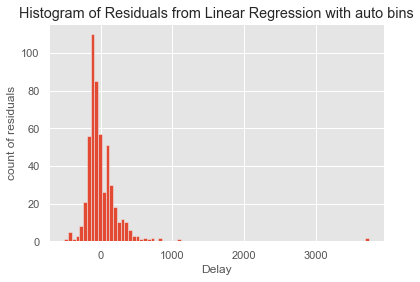

In [210]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram of Residuals from Linear Regression with auto bins")
plt.show()

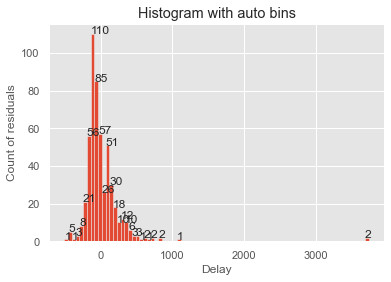

In [211]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridsearchCV for SVR

In [212]:
param_grid = {'C': [0.001, 0.01, 10, 100,1.0], 'gamma' : [0.001, 0.01, 0.1,1.0,'scale']}
grid_search = GridSearchCV(SVR(), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

SVR(C=100, gamma=0.001)
{'C': 100, 'gamma': 0.001}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 10, 100, 1.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 'scale']})>

#### SVR

In [213]:
svr_rbf = SVR(kernel='rbf', 
              C=bestParameters.get('C'),
              gamma=bestParameters.get('gamma'), epsilon=1)
svr_rbf.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(svr_rbf, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(svr_rbf, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)
y_pred_svr_rbf = svr_rbf.predict(test_x)
svr_rbf.score(test_x,test_y)

0.23651692678668929
0.11514331944367542
[0.28442333 0.1128478  0.10363253 0.38214629 0.39913685 0.37294949
 0.12004912 0.13296327 0.28616958 0.17085103]


0.12109949946393361

In [214]:
y_pred= y_pred_svr_rbf
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 103.06076747829174
Mean Squared Error (MSE): 84194.36979502351
Root Mean Squared Error (RMSE): 290.16266092490866
Explained Variance Score: 0.14575980596503568
Max Error: 3979.8675695541747
Median Absolute Error: 42.98652153263629
R^2: 0.12109949946393361


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

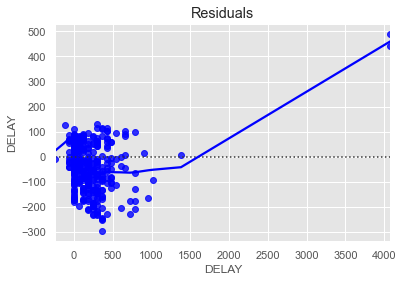

In [215]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

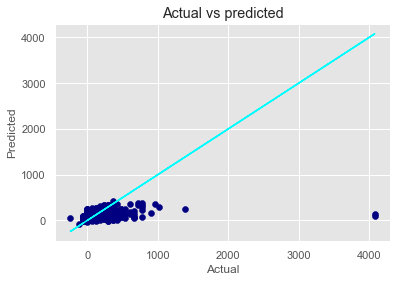

In [216]:
y_pred= svr_rbf.predict(test_x)
residuals = test_y - y_pred
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

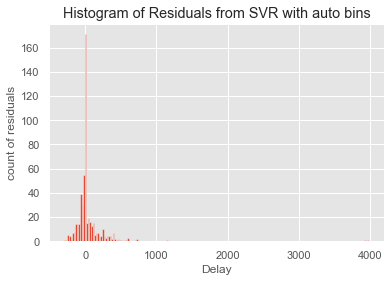

In [217]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram of Residuals from SVR with auto bins")
plt.show()

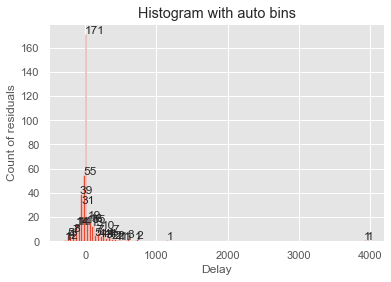

In [218]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridSearch for XGBoost model

In [219]:
param_grid = {'max_depth' : [1,2,3,4,5,6,7,8,9,10],
              'n_estimators': [10,15,20,25,100,500,600,700,800,900,1000]
             }
grid_search = GridSearchCV(xgb.XGBRegressor(objective ='reg:squarederror'), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
{'max_depth': 3, 'n_estimators': 1000}


<bound method BaseSearchCV.score of GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                              

#### XGBoost model

In [220]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.8, 
                          learning_rate = 1,
                          max_depth = bestParameters.get('max_depth'), 
                          alpha = 10, 
                          n_estimators = bestParameters.get('n_estimators'))
xg_reg.fit(train_x,train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores= cross_val_score(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)

y_pred_xg_reg = xg_reg.predict(test_x)
rmse = np.sqrt(mean_squared_error(test_y, y_pred_xg_reg))
print(xg_reg.score(test_x,test_y))

0.799143061674898
0.1400912729813443
[0.60321349 0.89691994 0.90010378 0.86173843 0.6127252  0.62159436
 0.92432929 0.9397989  0.68915187 0.94185537]
0.8631600190075235


In [221]:
y_pred= y_pred_xg_reg
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 68.2324254068721
Mean Squared Error (MSE): 13108.600979743986
Root Mean Squared Error (RMSE): 114.49279881173307
Explained Variance Score: 0.8635067985990188
Max Error: 769.4161987304688
Median Absolute Error: 36.25764846801758
R^2: 0.8631600190075235


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

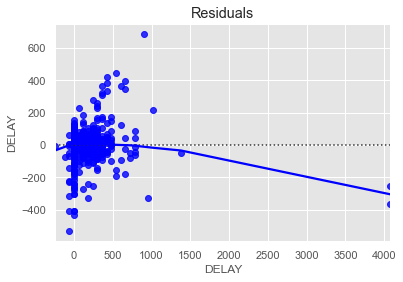

In [222]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

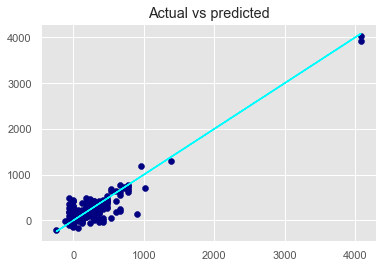

In [223]:
y_pred= xg_reg.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

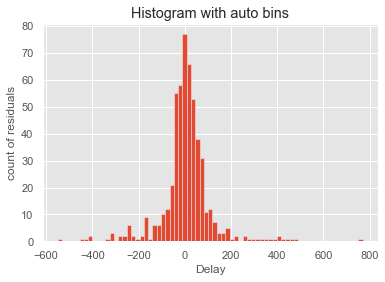

In [224]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram with auto bins")
plt.show()

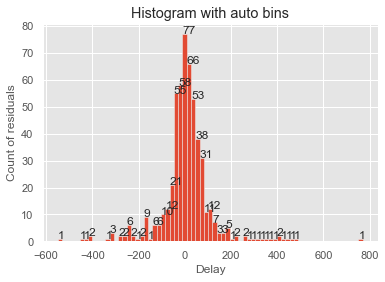

In [225]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

In [226]:
residuals.describe()

count    527.000000
mean       5.763661
std      114.456277
min     -547.996399
25%      -31.502555
50%        5.679430
75%       44.323448
max      769.416199
Name: DELAY, dtype: float64

#### GridSearch for DecisionTree

In [227]:
startTimeGS = datetime.now()
param_grid = {'criterion':['mse', 'friedman_mse', 'mae'],
              'splitter':['best','random']}

grid_rf = GridSearchCV(DecisionTreeRegressor(random_state =  0), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('MLPRegressor Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

MLPRegressor Grid Search with non-redundant variables took [ 0:00:03.220964 ] seconds.


In [228]:
print(bestModel)
print(bestParameters)
gridScores

DecisionTreeRegressor(random_state=0)
{'criterion': 'mse', 'splitter': 'best'}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'splitter': ['best', 'random']})>

In [229]:
regr = DecisionTreeRegressor(criterion = bestParameters.get('criterion'),
                             splitter = bestParameters.get('splitter'))
regr.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_regr = regr.predict(test_x)
regr.score(test_x,test_y)

0.6703178319408867
0.2712972598969089
[0.62313137 0.90657331 0.92737291 0.35257538 0.06844984 0.58122977
 0.79101535 0.928587   0.61612045 0.90812294]


0.8390540302829383

In [230]:
y_pred= y_pred_regr
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 49.07020872865275
Mean Squared Error (MSE): 15417.836812144213
Root Mean Squared Error (RMSE): 124.16858222652063
Explained Variance Score: 0.839184065599502
Max Error: 720.0
Median Absolute Error: 0.0
R^2: 0.8390540302829383


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

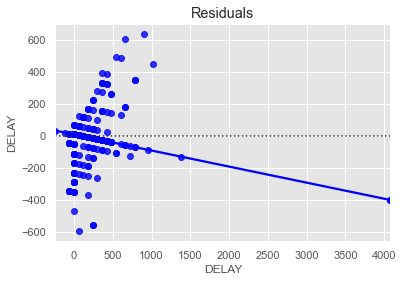

In [231]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

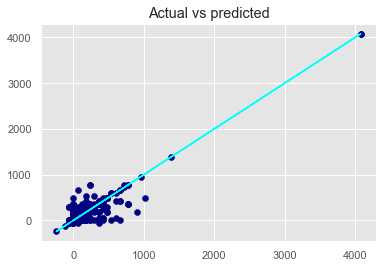

In [232]:
y_pred= regr.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

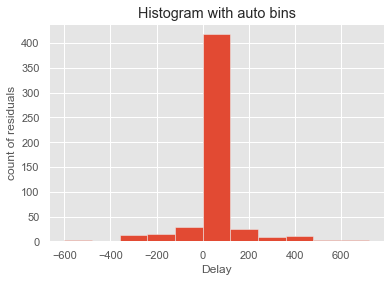

In [233]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram with auto bins")
plt.show()

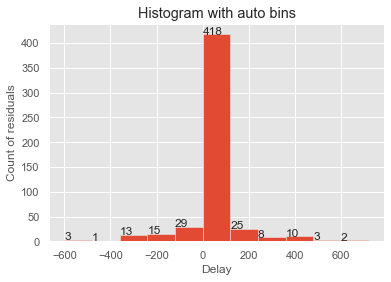

In [234]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str